In [1]:
# importeer libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels
import scipy
from scipy.stats import norm
import math
import numpy as np
import statsmodels.tsa.seasonal
import statsmodels.graphics.tsaplots
import matplotlib

In [5]:

df = pd.read_csv('helpdesk.csv')
df

,start_date,priority,experience_cat,team_size,budget,type,status,end_date
0,2025-04-01,medium,medium,7,43200,bug,completed,2025-05-30
1,2025-04-01,medium,medium,4,36800,feature,completed,2025-04-23
2,2025-04-01,medium,low,3,47700,bug,completed,2025-04-29
3,2025-04-01,medium,low,9,37000,chore,completed,2025-05-31
4,2025-04-01,medium,medium,4,58500,chore,completed,2025-04-15
...,...,...,...,...,...,...,...,...
8110,2025-10-31,medium,medium,8,60200,bug,ongoing,NaN
8111,2025-10-31,high,medium,4,71400,feature,ongoing,NaN
8112,2025-10-31,medium,low,7,41100,bug,ongoing,NaN
8113,2025-10-31,high,high,8,13400,bug,ongoing,NaN


In [10]:
df['start_date'] = pd.to_datetime(df['start_date'])

In [16]:
aantal_per_maand = (
    df
    .groupby(df['start_date'].dt.to_period('M'))
    .size()
    .reset_index(name='aantal')
)
aantal_per_maand['start_date'] = (
    aantal_per_maand['start_date']
    .dt.to_timestamp()          # -> 2025-04-01, 2025-05-01, ...
)

In [17]:
aantal_per_maand

,start_date,aantal
0,2025-04-01,956
1,2025-05-01,938
2,2025-06-01,845
3,2025-07-01,1290
4,2025-08-01,1116
5,2025-09-01,1407
6,2025-10-01,1563


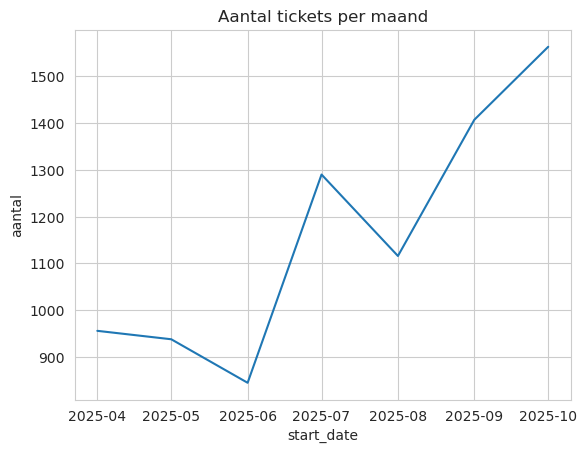

In [18]:
sns.lineplot(data=aantal_per_maand, x='start_date', y='aantal')
plt.title("Aantal tickets per maand")
plt.show()

In [19]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = statsmodels.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used",],)
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = statsmodels.tsa.stattools.kpss(timeseries, regression="c",
    nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"])
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


# voer ADF-test uit
adf_test(aantal_per_maand['aantal'])
kpss_test(aantal_per_maand['aantal'])

Results of Dickey-Fuller Test:
Test Statistic                 0.356155
p-value                        0.979779
#Lags Used                     1.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64
Results of KPSS Test:
Test Statistic           0.417987
p-value                  0.069402
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [21]:
aantal_per_maand['aantal_detrend'] = aantal_per_maand['aantal'] - \
                                                     aantal_per_maand['aantal'].shift(1)

In [23]:
adf_test(aantal_per_maand['aantal_detrend'].dropna())
kpss_test(aantal_per_maand['aantal_detrend'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.985463e+00
p-value                        7.990164e-10
#Lags Used                     1.000000e+00
Number of Observations Used    4.000000e+00
Critical Value (1%)           -7.355441e+00
Critical Value (5%)           -4.474365e+00
Critical Value (10%)          -3.126933e+00
dtype: float64
Results of KPSS Test:
Test Statistic           0.500000
p-value                  0.041667
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


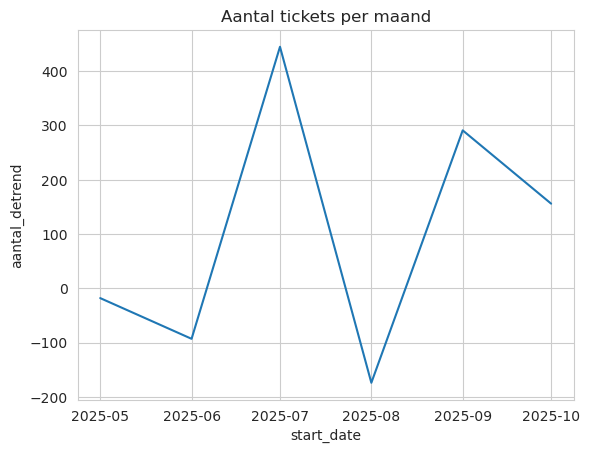

In [24]:
sns.lineplot(data=aantal_per_maand, x='start_date', y='aantal_detrend')
plt.title("Aantal tickets per maand")
plt.show()

In [26]:
aantal_per_maand['aantal_boxcox'], fitted_lambda = scipy.stats.boxcox(aantal_per_maand['aantal'])
fitted_lambda

-0.45597522927469486

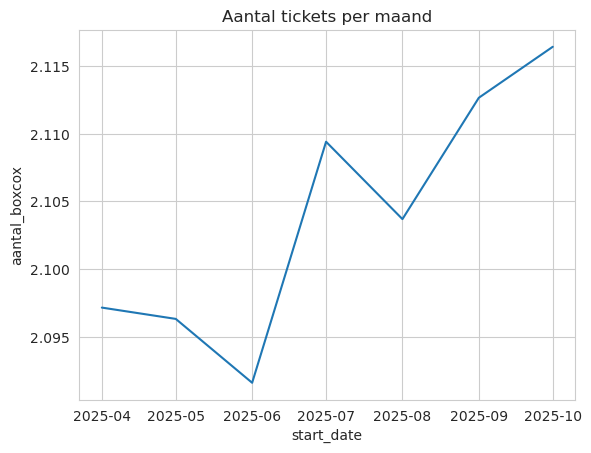

In [27]:
sns.lineplot(data=aantal_per_maand, x='start_date', y='aantal_boxcox')
plt.title("Aantal tickets per maand")
plt.show()

In [28]:
aantal_per_maand['aantal_boxcox_detrend'] = aantal_per_maand['aantal_boxcox'] - \
                                                     aantal_per_maand['aantal_boxcox'].shift(1)

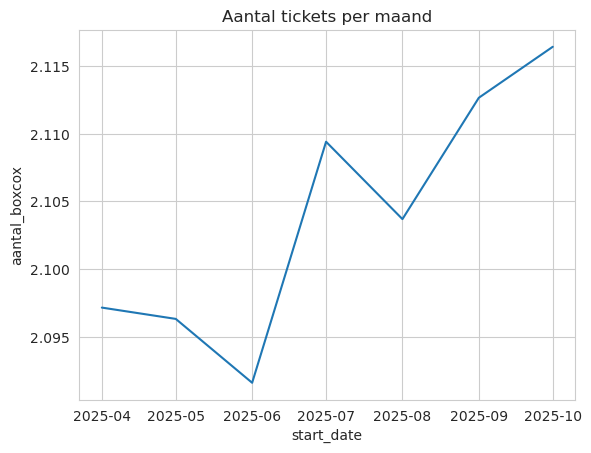

In [29]:
sns.lineplot(data=aantal_per_maand, x='start_date', y='aantal_boxcox')
plt.title("Aantal tickets per maand")
plt.show()

In [30]:
adf_test(aantal_per_maand['aantal_boxcox_detrend'].dropna())
kpss_test(aantal_per_maand['aantal_boxcox_detrend'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -23.394398
p-value                         0.000000
#Lags Used                      1.000000
Number of Observations Used     4.000000
Critical Value (1%)            -7.355441
Critical Value (5%)            -4.474365
Critical Value (10%)           -3.126933
dtype: float64
Results of KPSS Test:
Test Statistic           0.500000
p-value                  0.041667
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [31]:
aantal_per_maand['aantal_sqrt'] = np.sqrt(aantal_per_maand['aantal'])

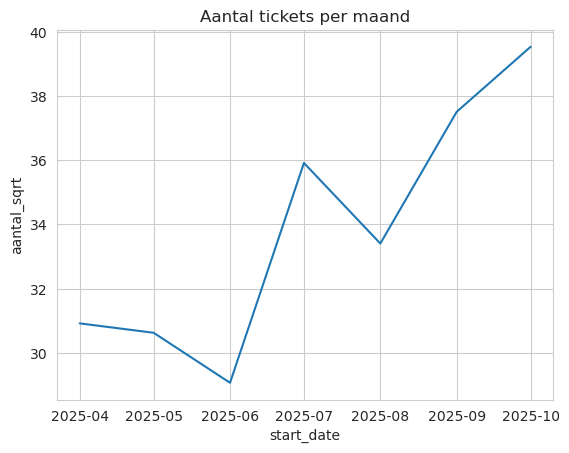

In [32]:
sns.lineplot(data=aantal_per_maand, x='start_date', y='aantal_sqrt')
plt.title("Aantal tickets per maand")
plt.show()

In [33]:
adf_test(aantal_per_maand['aantal_sqrt'].dropna())
kpss_test(aantal_per_maand['aantal_sqrt'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                 0.251104
p-value                        0.974987
#Lags Used                     1.000000
Number of Observations Used    5.000000
Critical Value (1%)           -6.045114
Critical Value (5%)           -3.929280
Critical Value (10%)          -2.986810
dtype: float64
Results of KPSS Test:
Test Statistic           0.416101
p-value                  0.070215
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


In [34]:
aantal_per_maand['aantal_sqrt_boxcox'], fitted_lambda = scipy.stats.boxcox(aantal_per_maand['aantal_sqrt'])
fitted_lambda

-0.9119504598295786

In [35]:
adf_test(aantal_per_maand['aantal_sqrt_boxcox'].dropna())
kpss_test(aantal_per_maand['aantal_sqrt_boxcox'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -0.805217
p-value                        0.817585
#Lags Used                     0.000000
Number of Observations Used    6.000000
Critical Value (1%)           -5.354256
Critical Value (5%)           -3.646238
Critical Value (10%)          -2.901198
dtype: float64
Results of KPSS Test:
Test Statistic           0.410060
p-value                  0.072819
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


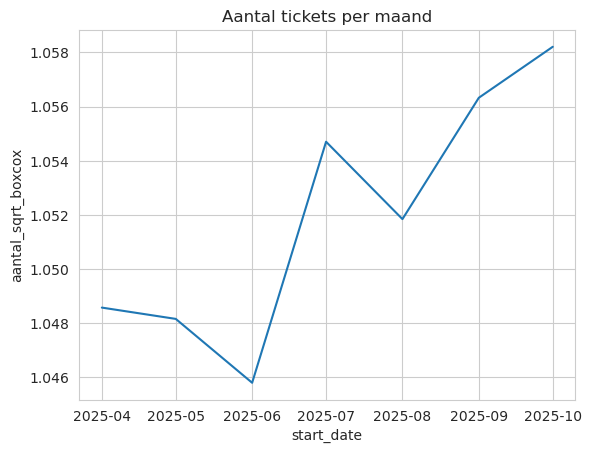

In [36]:
sns.lineplot(data=aantal_per_maand, x='start_date', y='aantal_sqrt_boxcox')
plt.title("Aantal tickets per maand")
plt.show()

In [40]:
aantal_per_maand['aantal_sqrt_detrend'] = aantal_per_maand['aantal_sqrt'] - \
                                                     aantal_per_maand['aantal_sqrt'].shift(1)

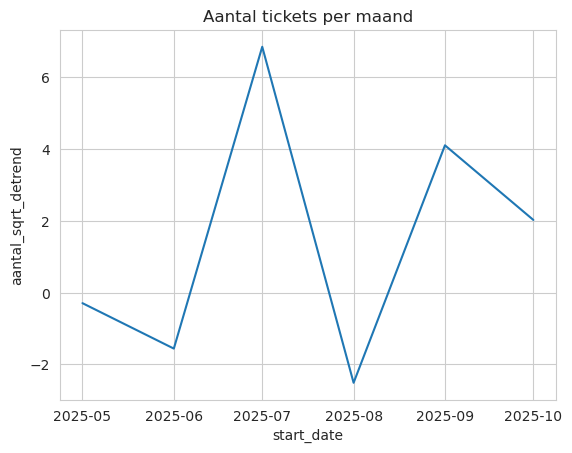

In [41]:
sns.lineplot(data=aantal_per_maand, x='start_date', y='aantal_sqrt_detrend')
plt.title("Aantal tickets per maand")
plt.show()

In [42]:
adf_test(aantal_per_maand['aantal_sqrt_detrend'].dropna())
kpss_test(aantal_per_maand['aantal_sqrt_detrend'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.384332e+01
p-value                        7.225353e-26
#Lags Used                     1.000000e+00
Number of Observations Used    4.000000e+00
Critical Value (1%)           -7.355441e+00
Critical Value (5%)           -4.474365e+00
Critical Value (10%)          -3.126933e+00
dtype: float64
Results of KPSS Test:
Test Statistic           0.500000
p-value                  0.041667
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
